In [ ]:
# conda create -n sctm python=3.8
#!pip install anndata
#!pip install matplotlib
#!pip install scanpy
#!pip install sctm
#!pip install numba==0.57.1
#!pip install squidpy==1.2.3

In [ ]:
import os
import random

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
import sctm
import squidpy as sq
import torch
from matplotlib import cm

sc.settings.figdir = "/data/project/AI4Omic/MASLD/results/ST/STAMP"
sc.set_figure_params(format="pdf", facecolor="white", dpi_save=300, figsize=(5,5))


%load_ext autoreload
%autoreload 2

/home/bailab/miniconda3/envs/sctm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# All 10x visium sections
sp_data_folder = '/data/project/AI4Omic/MASLD/data/Rawdata/Visium/'
section_ids = [file for file in os.listdir(sp_data_folder) if os.path.isdir(os.path.join(sp_data_folder, file))]
#section_ids.pop(section_ids.index('NAFL-171'))
adatas = {}
for section_id in section_ids:
    adata = sc.read_visium(path=os.path.join(sp_data_folder, section_id, 'outs'), count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='++')
    adata.obs['disease_status'] = section_id.split('-')[0]
    adata.obs['sample'] = section_id

    # Add clinical metadata
    clinical_info = pd.read_csv('/data/project/AI4Omic/MASLD/results/ST/clinical_info.csv')
    adata.obs['Age'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Age'].values[0]
    adata.obs['Sex'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Sex'].values[0]
    adata.obs['Steatosis'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Steatosis'].values[0]
    adata.obs['Ballooning'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Ballooning'].values[0]
    adata.obs['Lobular_inflammation'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Lobular_inflammation'].values[0]
    adata.obs['Fibrosis'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'Fibrosis'].values[0]
    adata.obs['NAS'] = clinical_info.loc[clinical_info['sample'] == adata.obs['sample'][0], 'NAS'].values[0]

    # filter low-quality spots
    sc.pp.filter_cells(adata, min_counts=400)
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    # update spatial uns
    file = list(adata.uns['spatial'].keys())[0]
    adata.uns['spatial'][section_id] = adata.uns['spatial'][file].copy()
    if file != section_id:
        del adata.uns['spatial'][file]
    print(adata.uns['spatial'].keys())

    #make spot name unique
    adata.obs_names =  [section_id + '_' + x for x in adata.obs_names]
    adata.obs['library_id'] = section_id
       
    adatas[section_id] = adata`

In [ ]:
adata_concat = ad.concat(adatas, uns_merge="only", join='outer', fill_value=0)
adata_concat = adata_concat[:, ~adata_concat.var_names.str.startswith(("MT-", 'RPL', 'RPS'))]
adata_concat = adata_concat[:, ~adata_concat.var_names.str.contains(("^HB[^(P)(E)]"))]
adata_concat.obs['disease_status'] = pd.Categorical(adata_concat.obs['disease_status'], categories=['CTRL', 'MASL', 'MASH'], ordered=True)
adata_concat.uns['disease_status_colors'] = ['#a6cee3', '#fdbf6f', '#b15928']
adata_concat

/tmp/ipykernel_2350933/1219875140.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_concat.obs['disease_status'] = pd.Categorical(adata_concat.obs['disease_status'], categories=['CTRL', 'MASLD', 'MASH'], ordered=True)


AnnData object with n_obs × n_vars = 48154 × 22357
    obs: 'in_tissue', 'array_row', 'array_col', 'disease_status', 'sample', 'Age', 'Sex', 'Steatosis', 'Ballooning', 'Lobular_inflammation', 'Fibrosis', 'NAS', 'n_counts', 'n_genes', 'library_id'
    uns: 'spatial', 'disease_status_colors'
    obsm: 'spatial'

In [ ]:
adata = adata_concat[adata_concat.obs['disease_status'] == 'MASH'].copy()
sctm.pp.filter_genes(adata, min_cutoff=0.01, max_cutoff=0.95)
adata.layers["counts"] = adata.X.copy()
sctm.pp.batch_highly_variable_genes(adata, n_top_genes=4000, layer="counts", subset=False, batch_key="library_id")
adata.obs["library_id"] = adata.obs["library_id"].astype("category")
sq.gr.spatial_neighbors(adata, library_key="library_id", n_rings=1) # sq.gr.spatial_neighbors(adata, n_rings=2, coord_type="grid", n_neighs=6)

In [ ]:
n_topics = 20
model = sctm.stamp.STAMP(
    adata[:, adata.var.highly_variable],
    n_topics,
    layer="counts",
    categorical_covariate_keys=["library_id"],
    mode="sign", # mode (str, optional): sign vs sgc(simplified graph convolutions).
    dropout = 0.1,
    n_layers=1,
    gene_likelihood="nb"
)

model.train(device = "cuda:0", early_stop=True, learning_rate=0.01)

In [ ]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
adata.obsm['X_stamp'] = topic_prop.values
for i in topic_prop.columns:
    adata.obs[i] = topic_prop[i]

adata.obsm["X_pca"] = topic_prop.to_numpy()
sc.pp.neighbors(adata, metric = "cosine")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['library_id', 'Fibrosis'], frameon=False, palette='tab10')

In [ ]:
adata.uns['beta'] = beta
adata.uns['topic_prop'] = topic_prop

In [ ]:
# re-load the STAMP results
#adata = sc.read_h5ad("/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_stamp.h5ad")
beta = adata.uns['beta'].copy()
topic_prop = adata.uns['topic_prop'].copy()

In [16]:
# Find topic signature genes
topic_sig = {}
for topic in topic_prop.columns:
    topic_sig[topic] = beta.nlargest(100, topic).index.tolist()

In [ ]:
# Save the topic signature genes to a CSV file
topic_sig_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in topic_sig.items()]))
topic_sig_df.to_csv('/data/project/AI4Omic/MASLD/results/ST/STAMP/topic_signature_genes.csv', index=False)

In [ ]:
for key in topic_sig.keys():
    print(topic_sig[key])

In [ ]:
# Mutl-cellular programs
for i in topic_prop.columns:
    sc.tl.score_genes(adata_sc, beta.nlargest(30, i).index, score_name = i + "_score")
#sc.pl.umap(adata_sc, color = [i + '_score' for i in topic_prop.columns], cmap = 'RdPu')
#sc.pl.dotplot(adata_sc, var_names=[i + '_score' for i in topic_prop.columns], cmap = 'Blues', groupby='cell_type_lvl2', dendrogram=True)

In [23]:
for i in topic_prop.columns:
    sc.tl.score_genes(adata_concat, beta.nlargest(100, i).index, score_name = i + "_score", ctrl_size = 100)
    adata_concat.obs[i] = topic_prop[i]
scores = [topic + "_score" for topic in topic_prop.columns]

In [ ]:
sctm.analysis.get_topic_enrichr(beta, geneset='KEGG_2019_Human', topics='all', topn_genes=20)

In [ ]:
# Visualize topic signature genes in scRNA-seq data
sc.pl.umap(adata_sc, color=np.intersect1d(topic_sig['Topic19'], adata_sc.var_names), ncols=5, cmap='RdPu', vmin=0, vmax='p99.9')

In [ ]:
import decoupler as dc
# Infer enrichment with ora using significant deg
msigdb = dc.get_resource('MSigDB')
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='go_biological_process'] #go_biological_process kegg_pathways

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']] #GOBP_ KEGG_

In [ ]:
enr_pvals[enr_pvals['FDR p-value'] < 0.05].sort_values('Combined score', ascending=False).head(15)

In [ ]:
# Visualization of enriched terms
top_genes = topic_sig['Topic19'][0:100]

# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

#enr_pvals[enr_pvals['FDR p-value'] < 0.05].sort_values('Combined score', ascending=False).head(15)

dc.plot_dotplot(
    enr_pvals[enr_pvals['FDR p-value'] < 0.05].sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.02,
    figsize=(3, 6),
    cmap='RdPu',
    title='GOBP enriched in Topic6',
    #save='/data/project/AI4Omic/MASLD/results/ST/STAMP/TopicFibrosis_GOBP.pdf',
    dpi=300
)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel('Combined score', fontsize=7)
plt.grid(False)
#plt.savefig('/data/project/AI4Omic/MASLD/results/ST/STAMP/TopicFibrosis_GOBP.pdf', dpi=300, bbox_inches='tight')
plt.savefig('/data/project/AI4Omic/MASLD/results/ST/STAMP/TopicLAMs_GOBP.pdf', dpi=300, bbox_inches='tight')

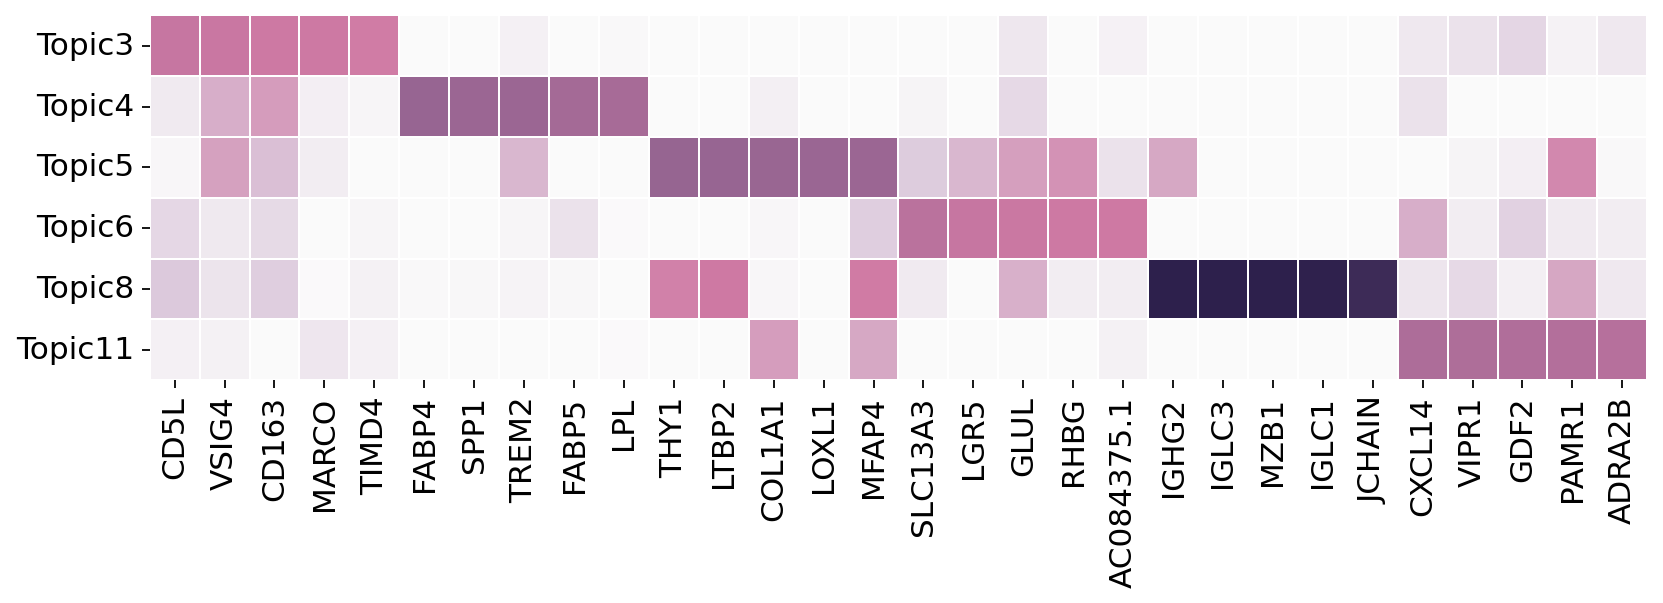

In [ ]:
# Select top 5 genes for each topic
#beta_filtered = beta.drop(columns=['Topic3', 'Topic10', 'Topic14', 'Topic12', 'Topic15', 'Topic16', 'Topic17', 'Topic19'])
beta_filtered = beta.loc[:, ['Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic8', 'Topic11']]
top_genes_per_topic = beta_filtered.apply(lambda x: x.nlargest(5).index, axis=0)

# Create a DataFrame for the heatmap
heatmap_data = beta_filtered.loc[top_genes_per_topic.values.flatten(order='F')].copy()
heatmap_data.index = pd.MultiIndex.from_tuples([(gene, topic) for topic in top_genes_per_topic.columns for gene in top_genes_per_topic[topic]])

# Plot the heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(heatmap_data.T, annot=False, cmap=cmap, xticklabels=[label.split('-')[0] for label in heatmap_data.index.get_level_values(0)], vmin=-1, vmax=6, linewidths=0.01, cbar=False)
plt.grid(False)
plt.title('')
plt.ylabel('')
plt.xlabel('')
plt.savefig('/data/project/AI4Omic/MASLD/results/ST/STAMP/Top5_genes_per_topic.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# Save results and reload them
#adata.write_h5ad("/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_stamp.h5ad")
#adata_concat.write_h5ad("/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_concat.h5ad")
adata = sc.read_h5ad("/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_stamp.h5ad")
adata_concat = sc.read_h5ad("/data/project/AI4Omic/MASLD/results/ST/STAMP/adata_concat.h5ad")
beta = adata.uns['beta'].copy()
topic_prop = adata.uns['topic_prop'].copy()

Spatial correlation between PPAR and MITF

In [15]:
adata.obs['disease_status'] = adata.obs['disease_status'].cat.rename_categories({'MASLD': 'MASL'})
#adata.obs['disease_status'] = adata.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'])
adata.obs['sample'] = adata.obs['sample'].str.replace('MASLD', 'MASL')
adata.obs['library_id'] = adata.obs['library_id'].str.replace('MASLD', 'MASL')
adata.obs_names = adata.obs_names.str.replace("MASLD", "MASL")
adata.uns['spatial'] = {x.replace("MASLD", "MASL"): v for x, v in adata.uns['spatial'].items()}

In [16]:
adata_concat.obs['disease_status'] = adata_concat.obs['disease_status'].cat.rename_categories({'MASLD': 'MASL'})
adata_concat.obs['disease_status'] = adata_concat.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'])
adata_concat.obs['sample'] = adata_concat.obs['sample'].str.replace('MASLD', 'MASL')
adata_concat.obs['library_id'] = adata_concat.obs['library_id'].str.replace('MASLD', 'MASL')
adata_concat.obs_names = adata_concat.obs_names.str.replace("MASLD", "MASL")
adata_concat.uns['spatial'] = {x.replace("MASLD", "MASL"): v for x, v in adata_concat.uns['spatial'].items()}

In [ ]:
#PPAR Pathway scoring
PPAR_signaling = ["ACAA1", "ACADL", "ACADM", "ACOX1", "ACOX2", "ACOX3", "ACSBG1", "ACSBG2","ACSL1", "ACSL3", "ACSL4", "ACSL5", "ACSL6", "ADIPOQ", "ANGPTL4", "APOA1","APOA2", "APOA5", "APOC3", "AQP7", "CD36", "CPT1A", "CPT1B", "CPT1C","CPT2", "CYP27A1", "CYP4A11", "CYP7A1", "CYP8B1", "DBI", "EHHADH", "FABP1","FABP2", "FABP3", "FABP4", "FABP5", "FABP6", "FABP7", "FADS2", "GK2","GK3", "HMGCS2", "ILK", "LPL", "ME1", "MMP1", "NR1H3", "OLR1","PCK1", "PCK2", "PDPK1", "PLIN1", "PLTP", "PPARA", "PPARD", "PPARG","RXRA", "RXRB", "RXRG", "SCD", "SCP2", "SLC27A1", "SLC27A2", "SLC27A4","SLC27A5", "SLC27A6", "SORBS1", "UCP1"]
sc.tl.score_genes(adata_concat, gene_list=PPAR_signaling, score_name='PPAR_pathway')

#MITF Regulon scoring
adjacencies = pd.read_csv('/data/project/AI4Omic/MASLD/results/scRNA/pyscenic/adj.tsv', index_col=False, sep='\t')
MITF_targets = adjacencies.loc[adjacencies.TF == 'MITF',:].sort_values('importance', ascending=False).target[0:50]
sc.tl.score_genes(adata_concat, gene_list=MITF_targets, score_name='MITF_regulon')

[<Axes: title={'center': 'CYP3A4'}, xlabel='spatial1', ylabel='spatial2'>]

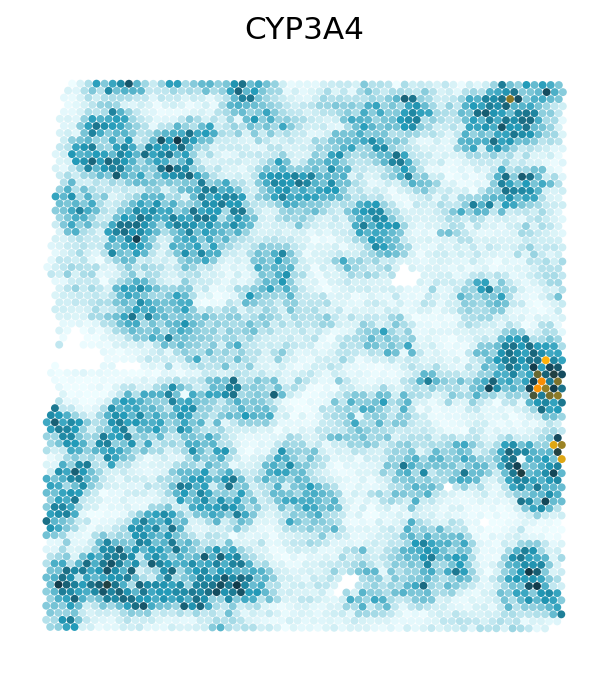

In [32]:
sc.pl.spatial(adata_concat[(adata_concat.obs['library_id'] == 'CTRL-179')], color='CYP3A4', ncols=1, show=False, cmap=sns.blend_palette(["#eefdff", '#239bb9', '#113847', '#fcb70c', "#f98d06"], as_cmap=True), img_key=None, size=1.5, frameon=False, library_id='CTRL-179', add_outline=False, colorbar_loc=None)